###Libraries

In [43]:
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.io as pio
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import warnings
warnings.filterwarnings('ignore')

### Load and explore data

In [44]:

df = pd.read_csv("disasters.csv")
print("Dataset shape:", df.shape)
print("\nFirst 10 samples:")
print(df.sample(10))
print("\nDataset description:")
print(df.describe())

Dataset shape: (10000, 7)

First 10 samples:
      Disaster_ID Disaster_Type   Location  Magnitude                 Date  \
6163         6164      Wildfire        USA   2.655627  2024-09-13 19:00:00   
3838         3839      Wildfire      Japan   7.955573  2024-06-08 22:00:00   
7898         7899     Hurricane     Brazil   4.383293  2024-11-25 02:00:00   
697           698    Earthquake      India   2.867865  2024-01-30 01:00:00   
2901         2902    Earthquake      Japan   4.848334  2024-04-30 21:00:00   
6169         6170       Tornado      India   5.539085  2024-09-14 01:00:00   
3577         3578     Hurricane      China   3.805652  2024-05-29 01:00:00   
2835         2836    Earthquake      China   1.136293  2024-04-28 03:00:00   
9431         9432       Tornado  Indonesia   7.617954  2025-01-27 23:00:00   
2552         2553      Wildfire     Brazil   2.772382  2024-04-16 08:00:00   

      Fatalities  Economic_Loss($)  
6163        5937      8.212553e+08  
3838        4308      

### Convert Date to datetime and extract features

In [45]:
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['DayOfYear'] = df['Date'].dt.dayofyear

print("\nMissing values:")
print(df.isnull().sum())

print("\nUnique values per column:")
print(df.nunique())

print("\nUnique Disaster Types:")
print(df['Disaster_Type'].unique())
print("\nUnique Locations:")
print(df['Location'].unique())


Missing values:
Disaster_ID         0
Disaster_Type       0
Location            0
Magnitude           0
Date                0
Fatalities          0
Economic_Loss($)    0
Year                0
Month               0
Day                 0
DayOfYear           0
dtype: int64

Unique values per column:
Disaster_ID         10000
Disaster_Type           5
Location                6
Magnitude           10000
Date                10000
Fatalities           6314
Economic_Loss($)    10000
Year                    2
Month                  12
Day                    31
DayOfYear             366
dtype: int64

Unique Disaster Types:
['Wildfire' 'Hurricane' 'Tornado' 'Flood' 'Earthquake']

Unique Locations:
['Brazil' 'Indonesia' 'China' 'India' 'USA' 'Japan']


### Create a copy for processing

In [46]:
df_processed = df.copy()

### Encode categorical variables using LabelEncoder

In [47]:
le_disaster = LabelEncoder()
le_location = LabelEncoder()

df_processed['Disaster_Type_Encoded'] = le_disaster.fit_transform(df['Disaster_Type'])
df_processed['Location_Encoded'] = le_location.fit_transform(df['Location'])

### Drop original categorical columns and Date

In [48]:
df_processed = df_processed.drop(['Disaster_Type', 'Location', 'Date'], axis=1)

print("\nProcessed data sample:")
print(df_processed.sample(10))


Processed data sample:
      Disaster_ID  Magnitude  Fatalities  Economic_Loss($)  Year  Month  Day  \
4847         4848   2.498851        8069      6.079759e+08  2024      7   20   
2001         2002   3.977900        4667      6.079861e+08  2024      3   24   
8903         8904   9.906171         353      1.022425e+08  2025      1    5   
2965         2966   3.994209        2830      5.308762e+08  2024      5    3   
4683         4684   3.048024        8320      3.346299e+08  2024      7   14   
3737         3738   7.275765        8551      7.527077e+08  2024      6    4   
2442         2443   5.109428        6368      5.177038e+08  2024      4   11   
8956         8957   8.739261         832      5.072621e+08  2025      1    8   
3638         3639   5.392522        9170      2.295651e+08  2024      5   31   
9442         9443   6.801733        6787      6.213505e+08  2025      1   28   

      DayOfYear  Disaster_Type_Encoded  Location_Encoded  
4847        202                     

### Data Visualizations

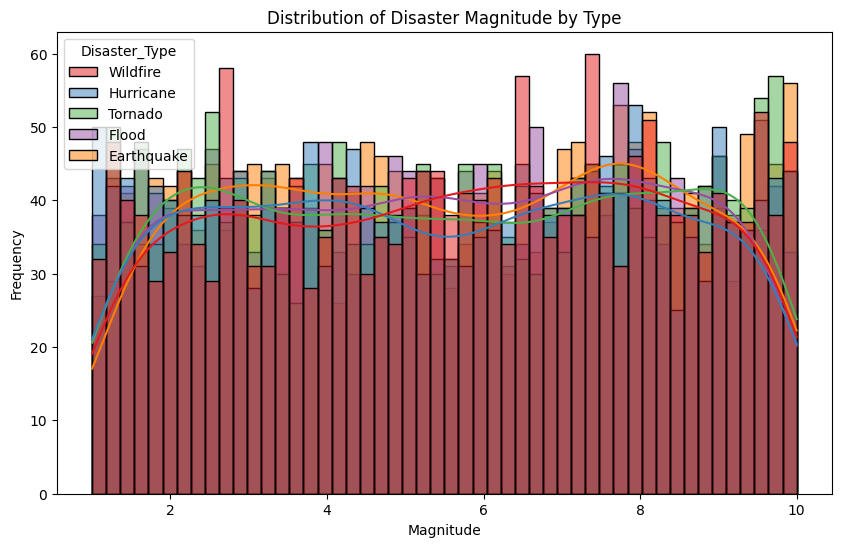

In [49]:
# 1. Distribution of Magnitude
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='Magnitude', kde=True, bins=50, hue='Disaster_Type', palette="Set1")
plt.title('Distribution of Disaster Magnitude by Type')
plt.xlabel('Magnitude')
plt.ylabel('Frequency')
plt.show()

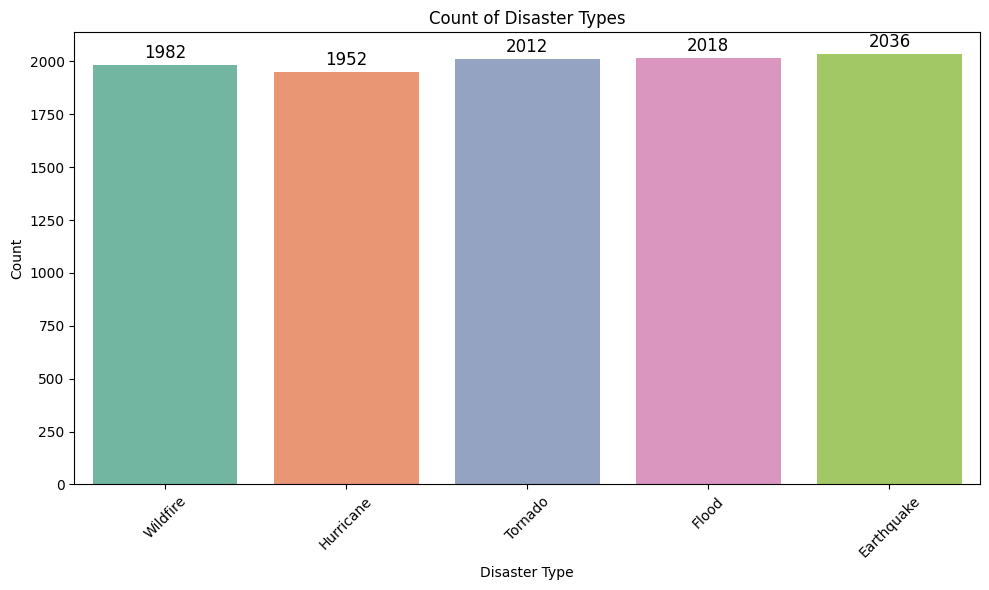

In [50]:
# 2. Count of Disaster Types
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=df, x='Disaster_Type', palette='Set2')
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='baseline', fontsize=12, color='black',
                xytext=(0, 5), textcoords='offset points')
plt.title('Count of Disaster Types')
plt.xlabel('Disaster Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

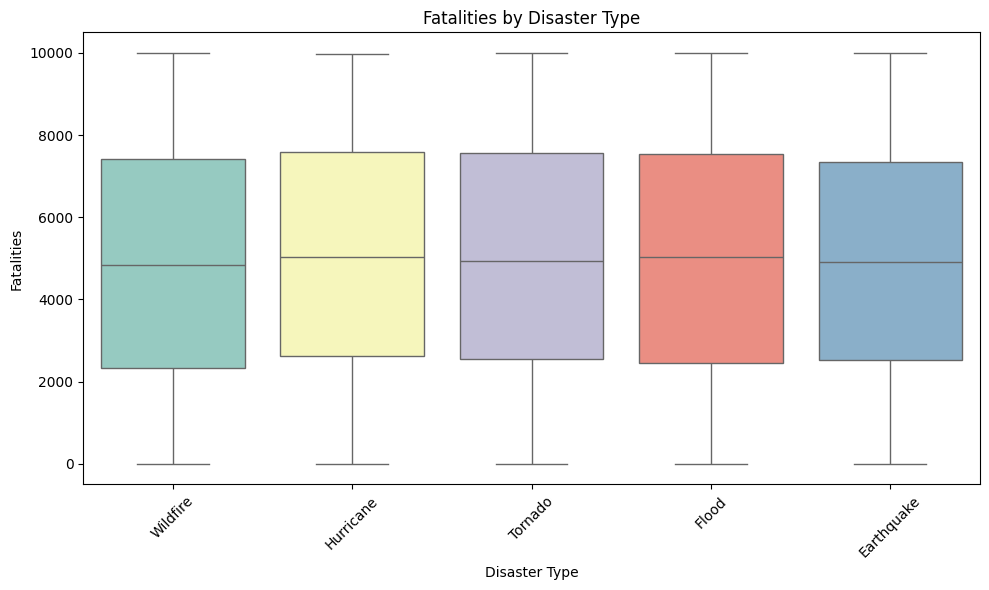

In [51]:
# 3. Boxplot of Fatalities by Disaster Type
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='Disaster_Type', y='Fatalities', palette='Set3')
plt.title('Fatalities by Disaster Type')
plt.xlabel('Disaster Type')
plt.ylabel('Fatalities')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

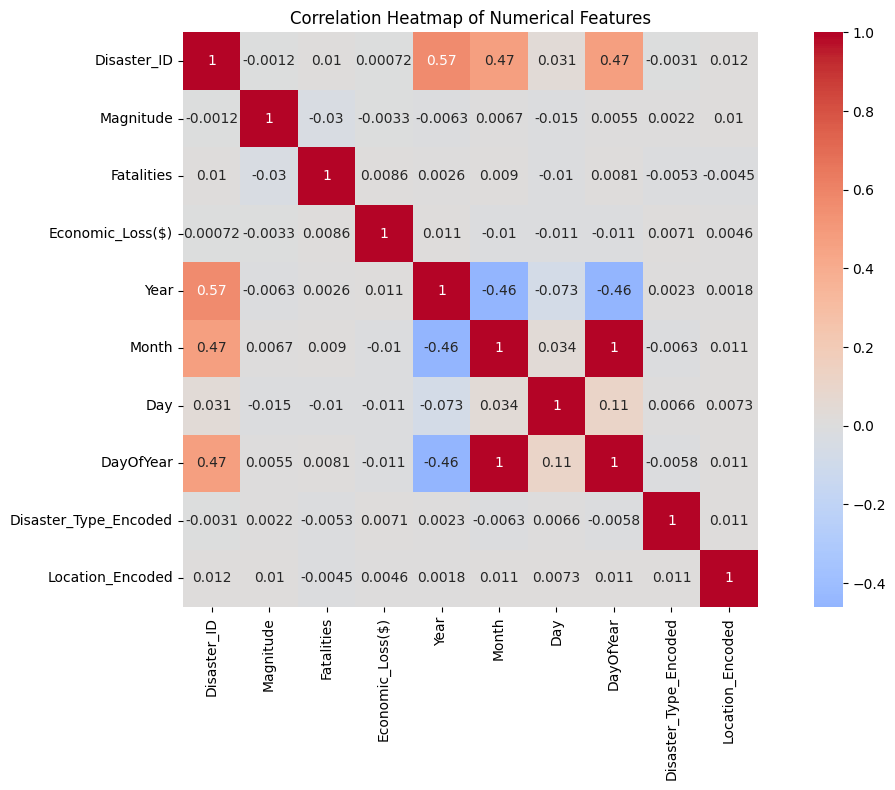

In [52]:
# 4. Correlation Heatmap
plt.figure(figsize=(12, 8))
# Create correlation matrix for numerical columns only
numerical_cols = df_processed.select_dtypes(include=[np.number]).columns
corr = df_processed[numerical_cols].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0, square=True)
plt.title('Correlation Heatmap of Numerical Features')
plt.tight_layout()
plt.show()

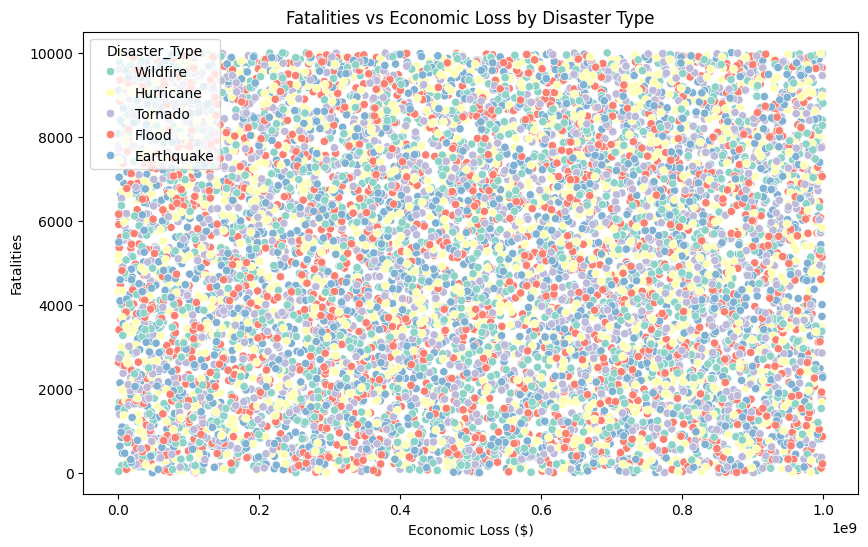

In [53]:
# 5. Fatalities vs Economic Loss
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Economic_Loss($)', y='Fatalities', hue='Disaster_Type', palette='Set3')
plt.title('Fatalities vs Economic Loss by Disaster Type')
plt.xlabel('Economic Loss ($)')
plt.ylabel('Fatalities')
plt.show()

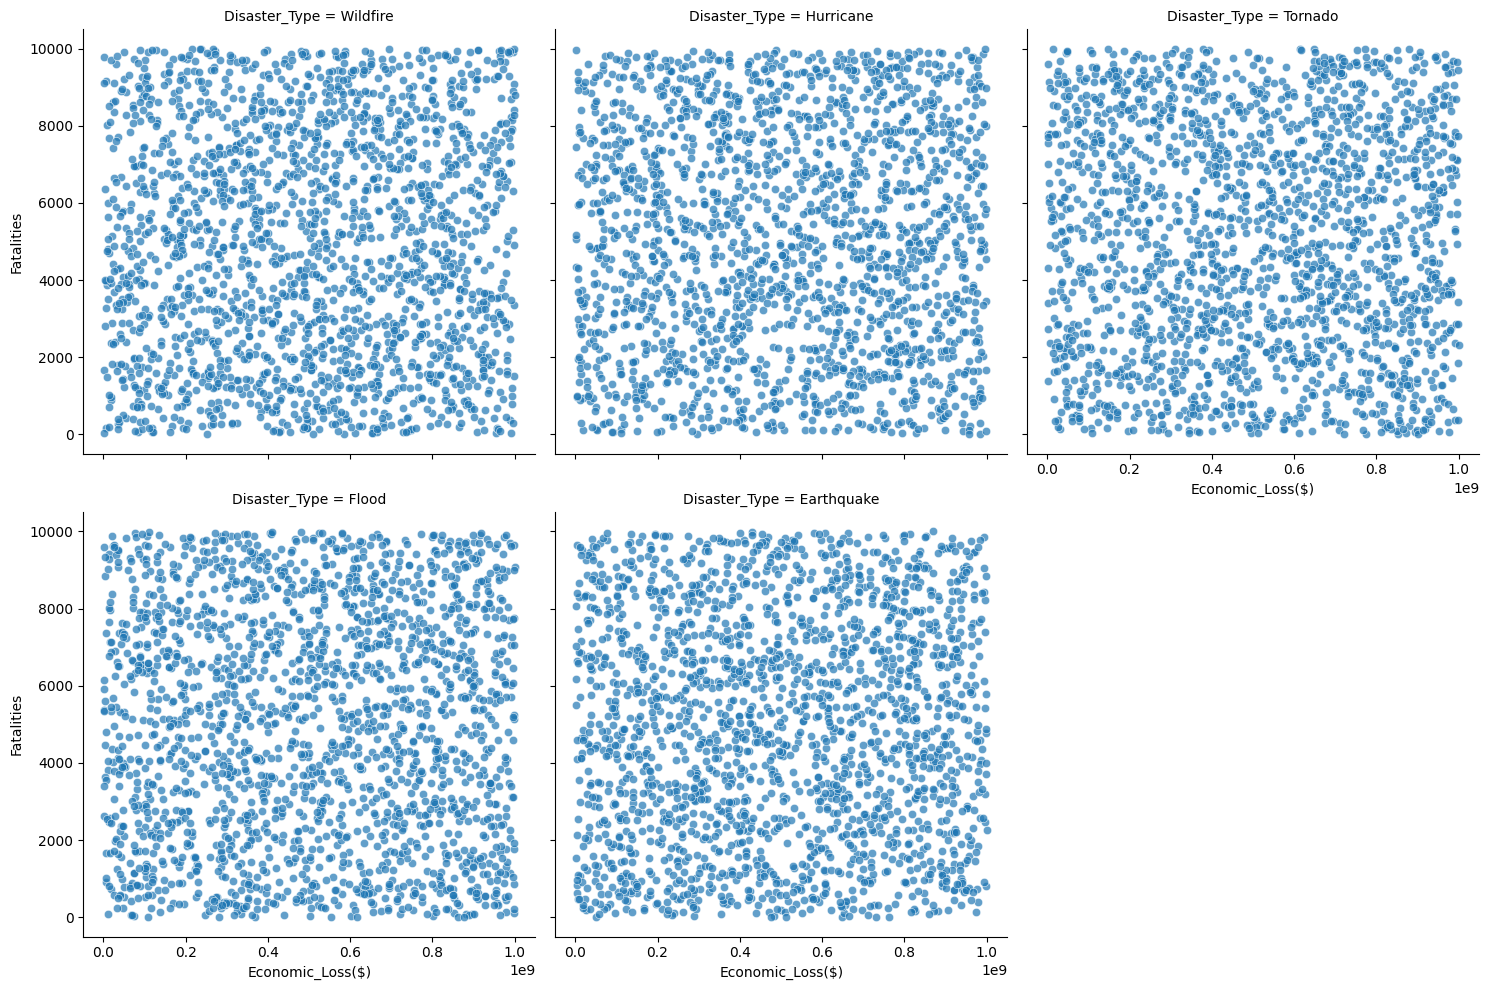

In [54]:
# 6. FacetGrid for detailed analysis
g = sns.FacetGrid(df, col='Disaster_Type', height=5, col_wrap=3)
g.map(sns.scatterplot, 'Economic_Loss($)', 'Fatalities', alpha=0.7)
g.add_legend()
plt.show()

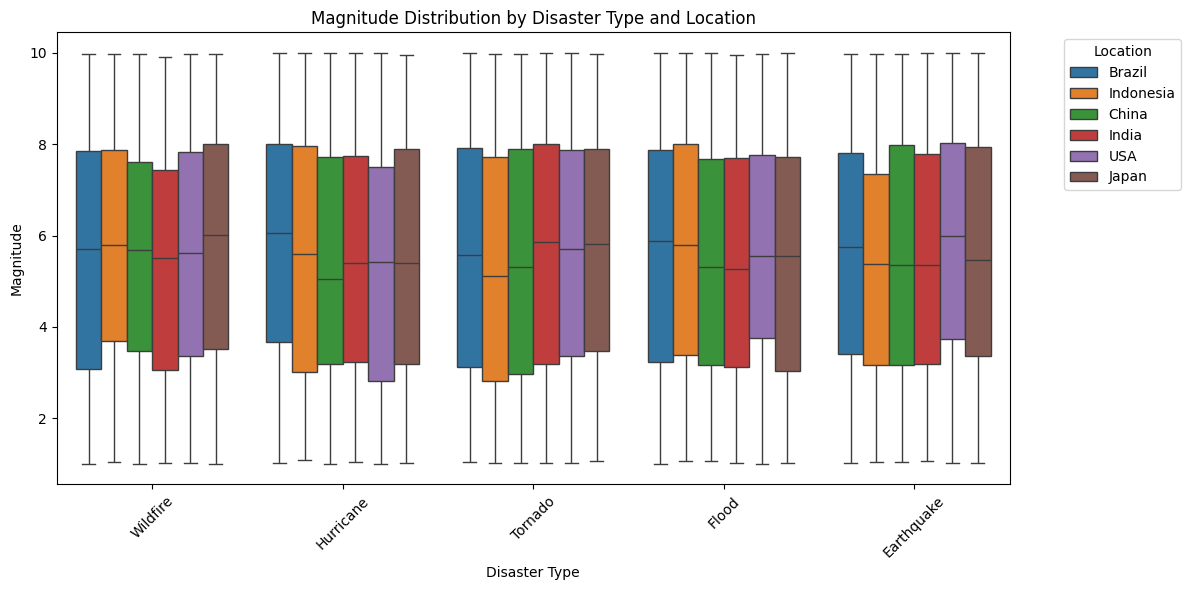

In [55]:
# 7. Disaster Type vs Magnitude by Location
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='Disaster_Type', y='Magnitude', hue='Location')
plt.title('Magnitude Distribution by Disaster Type and Location')
plt.xlabel('Disaster Type')
plt.ylabel('Magnitude')
plt.legend(title='Location', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Prepare features and target
### For this example, we'll predict Fatalities based on other features

In [56]:
feature_columns = ['Magnitude', 'Economic_Loss($)', 'Disaster_Type_Encoded',
                  'Location_Encoded', 'Year', 'Month', 'Day', 'DayOfYear']
target_column = 'Fatalities'

X = df_processed[feature_columns]
y = df_processed[target_column]

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

Features shape: (10000, 8)
Target shape: (10000,)


In [57]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [58]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [59]:
# Build Neural Network Model
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)  # Output layer for regression
])

In [60]:
# Compile the model
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mae'])

print("Model architecture:")
model.summary()

Model architecture:


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 128)            │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,521 (45.00 KB)

 Trainable params: 11,521 (45.00 KB)

 Non-trainable params: 0 (0.00 B)

In [61]:
# Train the model
print("\nTraining the model...")
history = model.fit(X_train_scaled, y_train,
                   batch_size=32,
                   epochs=100,
                   validation_split=0.2,
                   verbose=1)


Training the model...
Epoch 1/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 32096948.0000 - mae: 4869.5015 - val_loss: 12951636.0000 - val_mae: 2990.6755
Epoch 2/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 9675253.0000 - mae: 2609.0815 - val_loss: 9107971.0000 - val_mae: 2619.0745
Epoch 3/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 8873666.0000 - mae: 2549.4724 - val_loss: 8994535.0000 - val_mae: 2604.8401
Epoch 4/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 8839690.0000 - mae: 2541.3030 - val_loss: 8965565.0000 - val_mae: 2599.6570
Epoch 5/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 8638929.0000 - mae: 2520.5210 - val_loss: 8952339.0000 - val_mae: 2597.3433
Epoch 6/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 8657758.0000 - mae: 2521.8127 - val_loss: 8899997.0000 - val_mae: 2590.2324
Epoch 7/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 8634345.0000 - mae: 2518.8928 - val_loss: 8867053.0000 - val_mae: 2586.7219
Epoch 8/100
200/

In [62]:
# Make predictions
y_pred = model.predict(X_test_scaled)
y_pred = y_pred.flatten()

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  


In [63]:
# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"\nModel Performance:")
print(f"Mean Absolute Error: {mae:.2f}")
print(f"Mean Squared Error: {mse:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"R² Score: {r2:.4f}")


Model Performance:
Mean Absolute Error: 2579.91
Mean Squared Error: 8802389.00
Root Mean Squared Error: 2966.88
R² Score: -0.0232


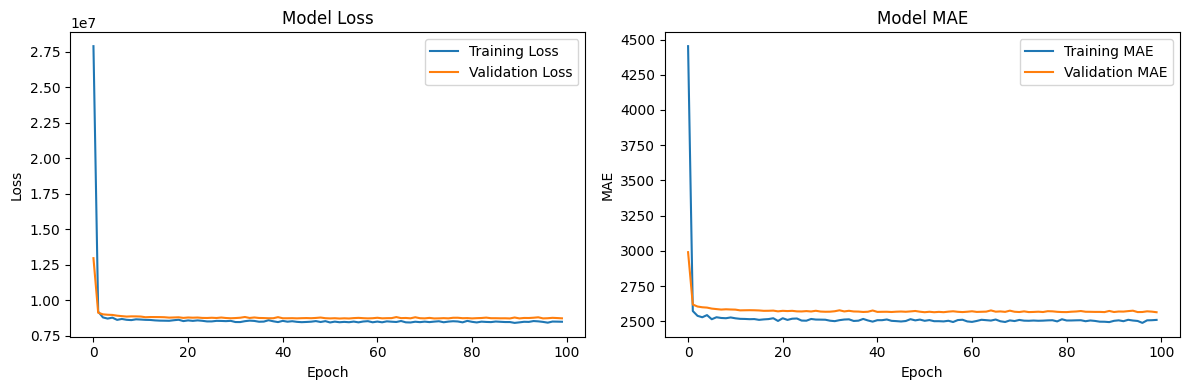

In [64]:
# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

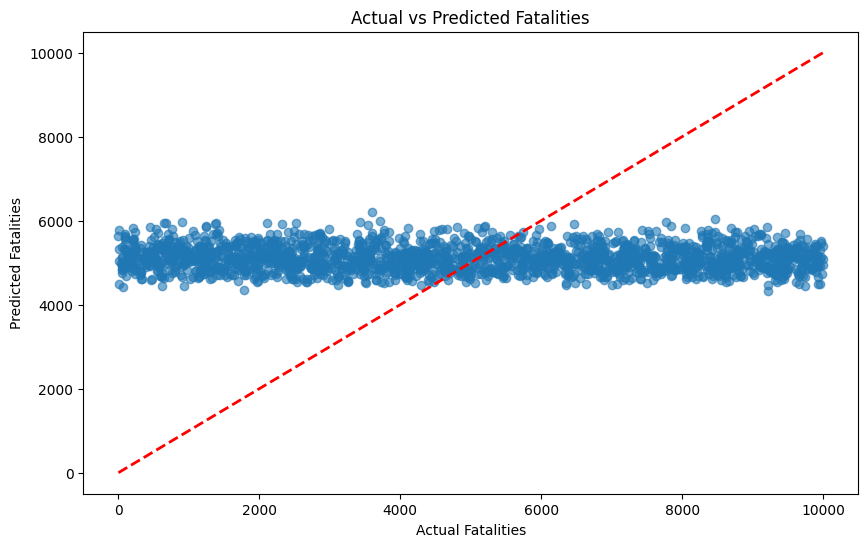

In [65]:
# Prediction vs Actual plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Fatalities')
plt.ylabel('Predicted Fatalities')
plt.title('Actual vs Predicted Fatalities')
plt.show()

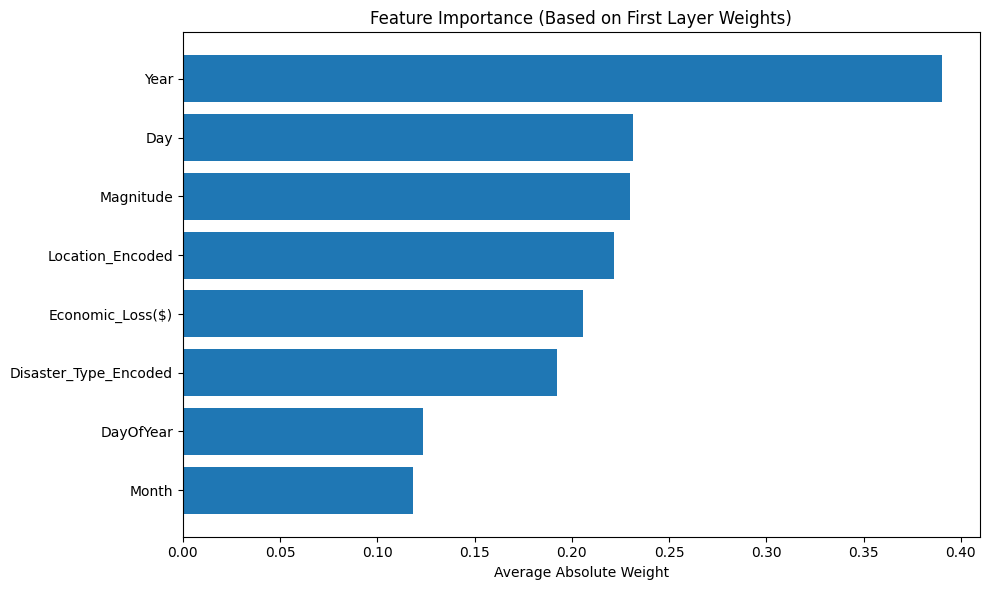

In [66]:
# Feature importance using model weights (simplified approach)
feature_importance = np.abs(model.layers[0].get_weights()[0]).mean(axis=1)
feature_names = feature_columns

plt.figure(figsize=(10, 6))
feature_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
feature_df = feature_df.sort_values('Importance', ascending=True)
plt.barh(feature_df['Feature'], feature_df['Importance'])
plt.title('Feature Importance (Based on First Layer Weights)')
plt.xlabel('Average Absolute Weight')
plt.tight_layout()
plt.show()

In [67]:
# Function for making new predictions
def predict_disaster_impact(magnitude, economic_loss, disaster_type, location, year, month, day):
    """
    Predict fatalities for a new disaster scenario
    """
    # Encode categorical variables
    disaster_encoded = le_disaster.transform([disaster_type])[0]
    location_encoded = le_location.transform([location])[0]

    # Calculate day of year
    from datetime import datetime
    day_of_year = datetime(year, month, day).timetuple().tm_yday

    # Create feature array
    features = np.array([[magnitude, economic_loss, disaster_encoded,
                         location_encoded, year, month, day, day_of_year]])

    # Scale features
    features_scaled = scaler.transform(features)

    # Make prediction
    prediction = model.predict(features_scaled)[0][0]

    return max(0, prediction)  # Ensure non-negative prediction

### Example prediction

In [68]:
print(f"\nExample Prediction:")
print(f"Disaster: Earthquake, Location: Japan, Magnitude: 7.5, Economic Loss: $1B")
example_prediction = predict_disaster_impact(
    magnitude=7.5,
    economic_loss=1000000000,
    disaster_type='Earthquake',
    location='Japan',
    year=2024,
    month=3,
    day=15
)
print(f"Predicted Fatalities: {example_prediction:.0f}")





Example Prediction:
Disaster: Earthquake, Location: Japan, Magnitude: 7.5, Economic Loss: $1B
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Predicted Fatalities: 5098


### Save the cleaned/processed data to CSV

In [69]:
df_processed.to_csv("data.csv", index=False)
print("✅ Cleaned data saved to data.csv")


✅ Cleaned data saved to data.csv
